#  Clusters 

# Setup

## Libraries

In [1]:
from polo2 import PoloDb
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

## Pragmas

In [2]:
%matplotlib inline

## Data

In [3]:
proj_dir = "/Users/rca2t/CODE/polo2-test/PUB/winereviews/"

In [4]:
corpus_db_file = proj_dir + '/winereviews-corpus.db'
cdb = PoloDb(corpus_db_file)
ctabs = cdb.get_table_names()

In [5]:
model_db_file = proj_dir + '/winereviews-mallet-20topics.db'
mdb = PoloDb(model_db_file)
mtabs = mdb.get_table_names()

##  Functions

In [6]:
# NB: If linkage method = 'centroid', 'median' and 'ward', 
# then distance metric = 'euclidean'. 
# Other methods (for cosine): 'single', 'complete', 'average', 'weighted'.

def get_tree(matrix, dist_metric='euclidean', linkage_method='ward'):
    sims = pdist(matrix, metric=dist_metric)
    tree = sch.linkage(sims, method=linkage_method)
    return pd.DataFrame(tree)

def hca(matrix, dist_metric='euclidean', linkage_method='ward', color_thresh=.3, figsize=(5, 10)):
    sims = pdist(matrix, metric=dist_metric)
    tree = sch.linkage(sims, method=linkage_method)
    labels = matrix.index
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left", 
                                count_sort=True,
                                distance_sort=True, 
                                above_threshold_color='.75',
                                color_threshold=color_thresh)
    plt.tick_params(axis='both', which='major', labelsize=14)

In [7]:
def euclidean_distance(x, y):   
    return np.sqrt(np.sum((x - y) ** 2))

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

def l1_normalize(v):
    norm = np.sum(v)
    return v / norm

def l2_normalize(v):
    norm = np.sqrt(np.sum(np.square(v)))
    return v / norm

# Preprocess

## Restrict observations

In [8]:
doc = cdb.get_table('doc', set_index=True)

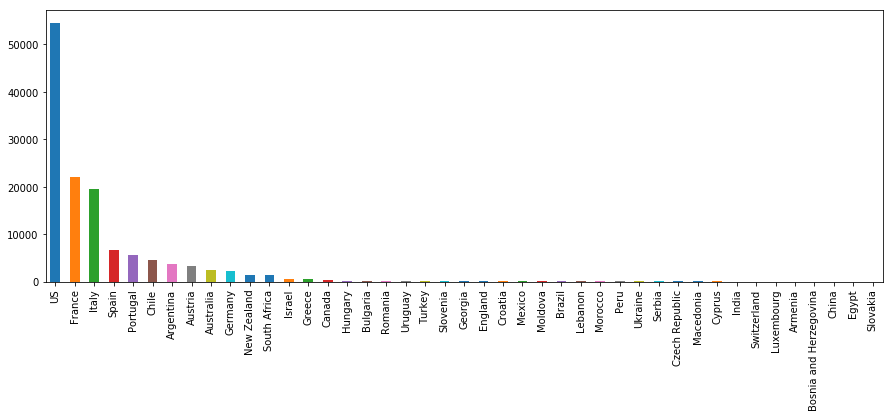

In [9]:
doc.doc_label.value_counts().plot(kind='bar', figsize=(15, 5))

In [10]:
topN = 15

In [11]:
TOPS = doc.doc_label.value_counts().index.tolist()[:topN]

In [12]:
TOPS

['US',
 'France',
 'Italy',
 'Spain',
 'Portugal',
 'Chile',
 'Argentina',
 'Austria',
 'Australia',
 'Germany',
 'New Zealand',
 'South Africa',
 'Israel',
 'Greece',
 'Canada']

## Restrict features

In [13]:
vocab = cdb.get_table('token')

In [14]:
vocab = vocab.sort_values('tfidf_sum', ascending=False).head(1000)

# Cluster

## By Topic

In [15]:
M = mdb.get_table('topicdoc_label_matrix')

In [16]:
M = M.set_index('doc_group')

<Figure size 432x288 with 0 Axes>

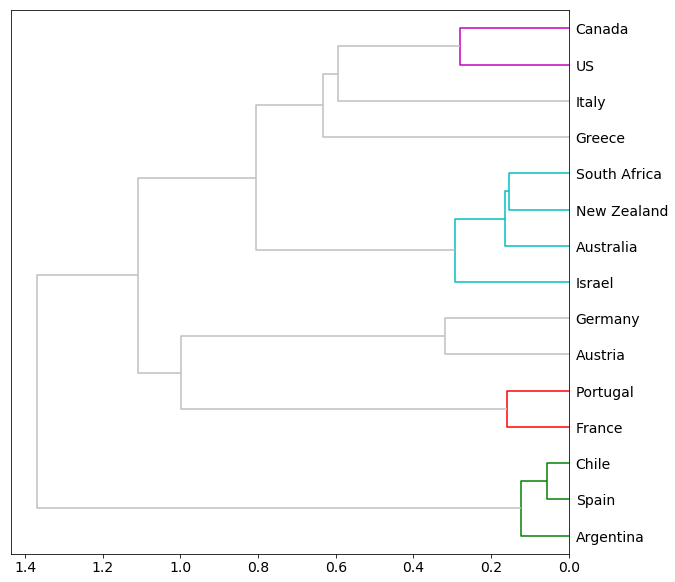

In [17]:
hca(M.loc[TOPS], figsize=(10,10))

In [18]:
# hca(M.loc[TOPS].T, figsize=(10,10))

## By Bigram Counts

## By Bigram Counts

In [19]:
M1 = cdb.get_table('ngrambidoc_group_matrix')
M1 = M1.set_index('ngram').T
M1 = M1.drop('nan')

<Figure size 432x288 with 0 Axes>

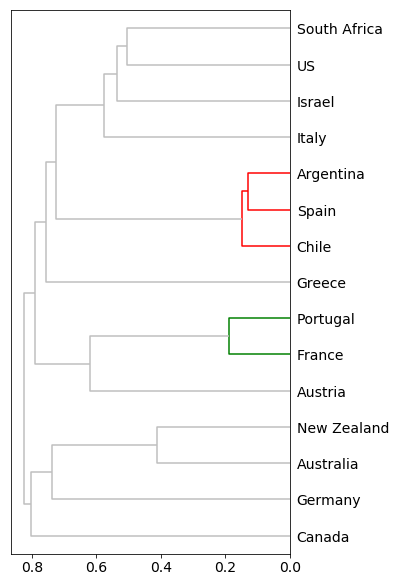

In [20]:
hca(M1.loc[TOPS], 'cosine', 'weighted')

## By TFIDF

In [21]:
bow = cdb.get_table('doctokenbow')
bow = bow.set_index(['doc_id', 'token_id'])
doc = cdb.get_table('doc')
doc = doc.set_index('doc_id')
# bow['label'] = doc.doc_label

In [22]:
bow = bow.join(doc.doc_label, on='doc_id')

In [23]:
M2 = bow.groupby(['doc_label', 'token_id']).tfidf.sum().to_frame().unstack().fillna(0)
M2.columns = M2.columns.droplevel(0)

In [24]:
# X = l1_normalize(M2.loc[TOPS, vocab.token_id])
X = M2.loc[TOPS, vocab.token_id]

<Figure size 432x288 with 0 Axes>

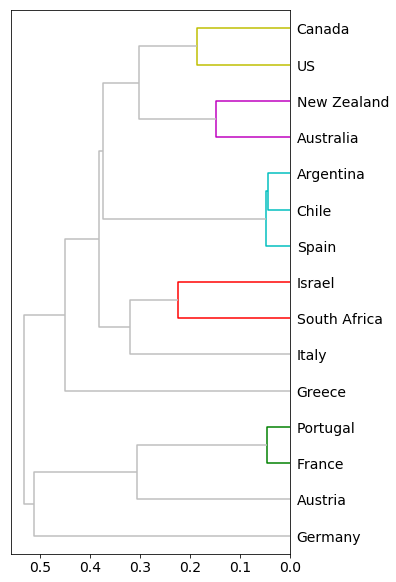

In [25]:
hca(X, 'cosine', 'weighted')

## By Bigram TFIDF

In [26]:
ngbow = cdb.get_table('ngrambidoc')
ngbow = ngbow.set_index(['ngram', 'doc_id']).sort_index()
ngbow['label'] = doc.doc_label
ngbow = ngbow.join(doc.doc_label, on='doc_id')
bigrams = cdb.get_table('ngrambi')
bigrams = bigrams.set_index('ngram')

In [27]:
ngbow['tfidf'] = (ngbow['tf'] / ngbow.groupby('doc_id')['tf'].count()) * bigrams['idf']
# bigrams['tfidf_sum'] = docbigrams.groupby('ngram').tfidf.sum()

In [28]:
M3 = ngbow.groupby(['doc_label', 'ngram']).tfidf.sum().to_frame().unstack().fillna(0)
M3.columns = M3.columns.droplevel(0)

In [29]:
X = M3.loc[TOPS]

<Figure size 432x288 with 0 Axes>

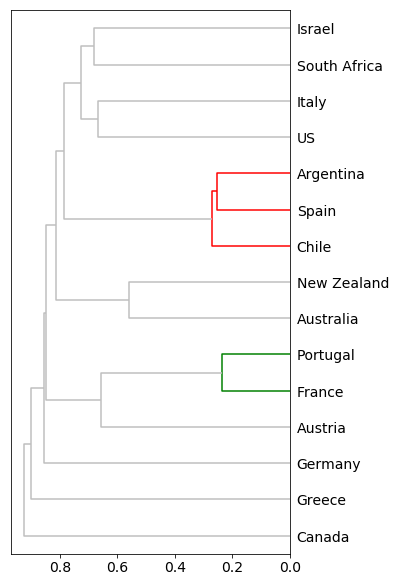

In [30]:
hca(X, 'cosine', 'weighted')

## By  TFIDF (using SQL)

In [31]:
import sqlite3
import pandas as pd

In [32]:
sql = """
select doc_label, token_id, sum(tfidf) as tfidf_sum
from doctokenbow join doc using(doc_id)
where doc_label is not null
group by doc_label, token_id
"""

In [33]:
with sqlite3.connect(corpus_db_file) as db:
    df = pd.read_sql_query(sql, db)
df = df.set_index(['doc_label','token_id'])
M4 = df.unstack().fillna(0)
M4.columns = M4.columns.droplevel(0)

<Figure size 432x288 with 0 Axes>

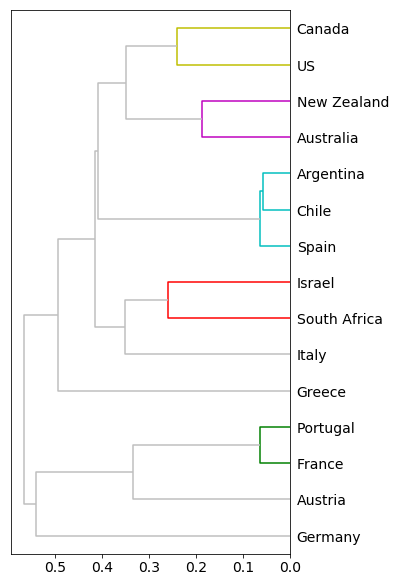

In [34]:
hca(M4.loc[TOPS], 'cosine', 'weighted')

# Observations

These seem certain traditions of wine:

1. France / Portugal
1. Spain / Argentina / Chile

Less certain are:

1. US / Italy
1. Germany / Austria

Although -- The US is always closer to Italy than to France!

# SciKit Learn

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

In [36]:
corpus = pd.read_csv('winereviews.csv')

In [37]:
corpus.head()

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [38]:
def create_matrix(corpus, feature):
    corpus_label = corpus.groupby(feature).description.apply(lambda x: ' '.join(x))
#     counts = corpus[feature].value_counts().to_frame().rename(columns={feature:'n'})
#     corpus_label['counts'] = counts
    vectorizer = TfidfVectorizer(use_idf=True)
    X = vectorizer.fit_transform(corpus_label)
    df = pd.DataFrame(X.todense(), index=corpus_label.index)
    return df

##  By Topic

In [39]:
doctopic = mdb.get_table('doctopic')
dtm = doctopic.set_index(['doc_id', 'topic_id']).topic_weight.unstack()
corpus['top_topic'] = dtm.idxmax(1)
topic = mdb.get_table('topic')
topic['title'] = topic.apply(lambda x: "T{}: {}".format(x.topic_id, x.topic_words), 1)

In [40]:
top_topics = create_matrix(corpus, 'top_topic')
top_topics.index = topic.title

<Figure size 432x288 with 0 Axes>

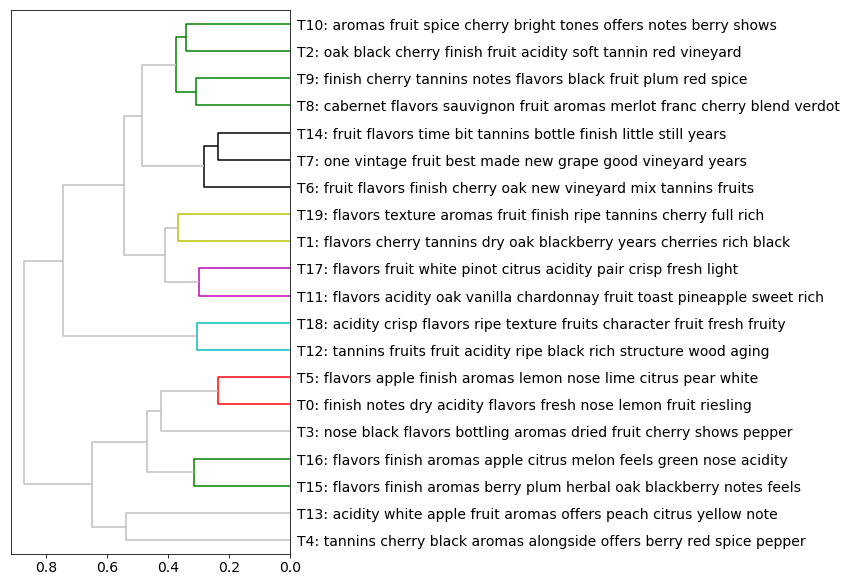

In [41]:
hca(top_topics, color_thresh=.4)

In [42]:
corpus.groupby(['top_topic','taster_name']).id.count().unstack().fillna(0).T.style.background_gradient()

top_topic,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
taster_name,,,,,,,,,,,,,,,,,,,,
Alexander Peartree,26,0,4,11,8,101,4,4,27,136,3,9,3,6,7,14,18,25,2,7
Anna Lee C. Iijima,3347,25,16,4,10,107,10,12,45,595,5,36,14,12,22,10,4,115,8,18
Anne Krebiehl MW,3282,16,29,7,11,28,9,6,4,72,4,5,25,3,48,2,8,67,32,27
Carrie Dykes,9,1,2,6,3,35,0,0,1,57,1,2,0,2,3,4,10,0,1,2
Christina Pickard,0,1,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,1,1,0
Fiona Adams,0,0,0,1,2,3,0,0,1,16,0,0,0,2,1,0,1,0,0,0
Jeff Jenssen,5,4,0,15,16,198,0,1,24,158,4,13,0,17,0,9,5,18,1,3
Jim Gordon,31,61,31,4,7,126,20,12,19,74,6,70,29,16,33,31,26,294,57,3230
Joe Czerwinski,299,107,38,20,5,914,85,207,53,2220,11,226,27,9,315,69,129,296,47,70


## By Country

In [43]:
countries = create_matrix(corpus, 'country')

In [44]:
# counts = corpus['country'].value_counts().to_frame().rename(columns={'country':'n'})

In [45]:
# top_countries = countries.sum(1).sort_values(ascending=False).head(15).index
top_countries = countries.sum(1).sort_values().tail(20).index

<Figure size 432x288 with 0 Axes>

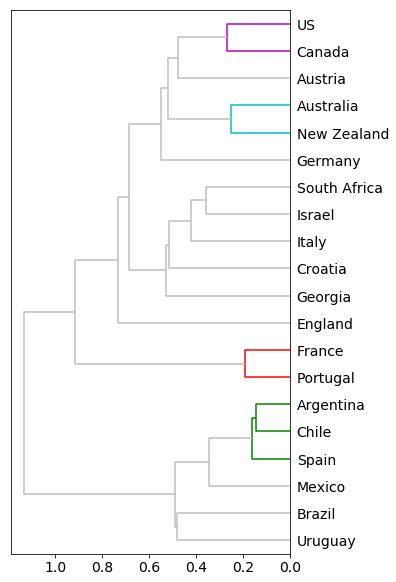

In [46]:
hca(countries.loc[top_countries], color_thresh=.3)

<Figure size 432x288 with 0 Axes>

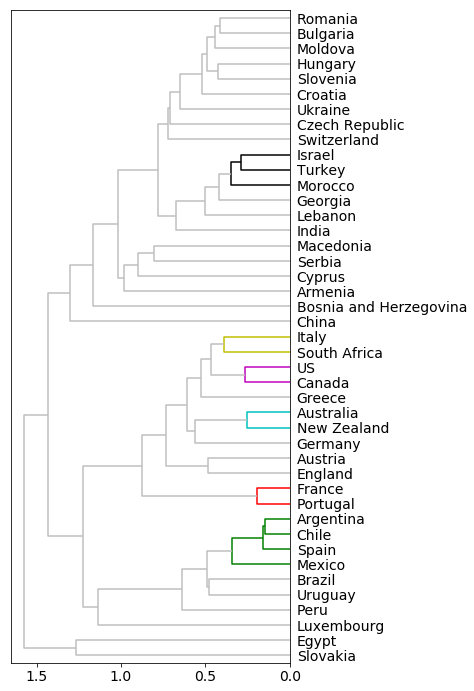

In [47]:
top_countries = countries.sum(1).sort_values().tail(100).index
hca(countries.loc[top_countries], color_thresh=.4, figsize=(5,12))

In [48]:
countries_no_voss = create_matrix(corpus[corpus.taster_name != 'Roger Voss'], 'country')
top_countries_no_voss = countries_no_voss.sum(1).sort_values().tail(100).index

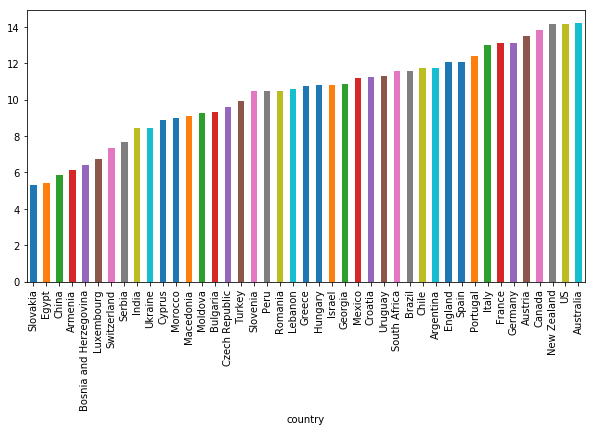

In [49]:
countries_no_voss.sum(1).sort_values().plot(kind='bar', figsize=(10,5))

<Figure size 432x288 with 0 Axes>

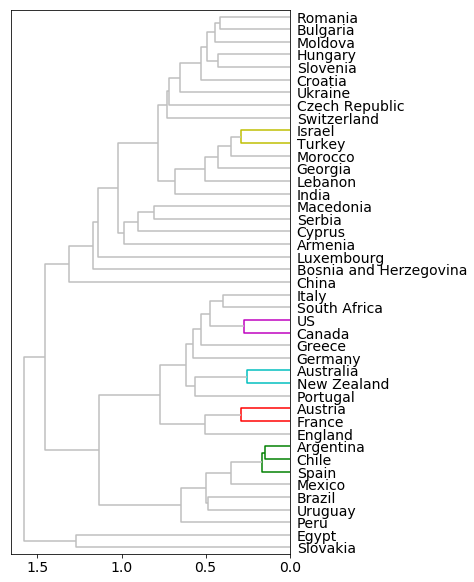

In [50]:
hca(countries_no_voss.loc[top_countries_no_voss], color_thresh=.3)

## By Taster

In [51]:
tasters = create_matrix(corpus, 'taster_name') 

<Figure size 432x288 with 0 Axes>

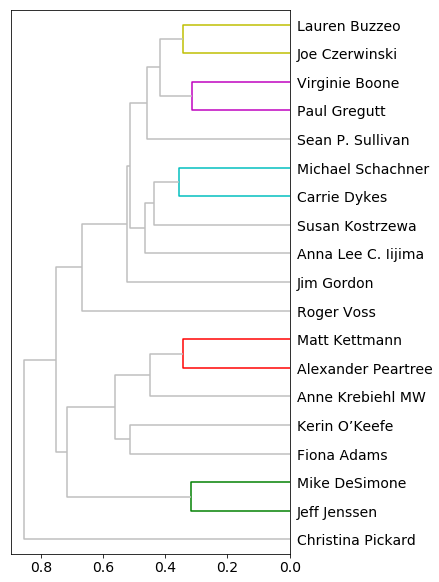

In [52]:
hca(tasters, color_thresh=.4)

## By Variety

In [53]:
varieties =  create_matrix(corpus, 'variety')

<Figure size 432x288 with 0 Axes>

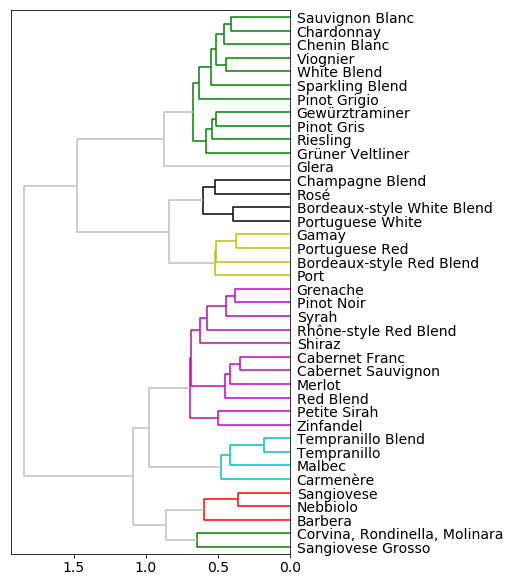

In [54]:
# top_varieties = varieties.sum(1).sort_values(ascending=False).head(40).index
top_varieties = corpus['variety'].value_counts().head(40).index
hca(varieties.loc[top_varieties], color_thresh=.7)

## By Points

In [55]:
points = create_matrix(corpus, 'points')

<Figure size 432x288 with 0 Axes>

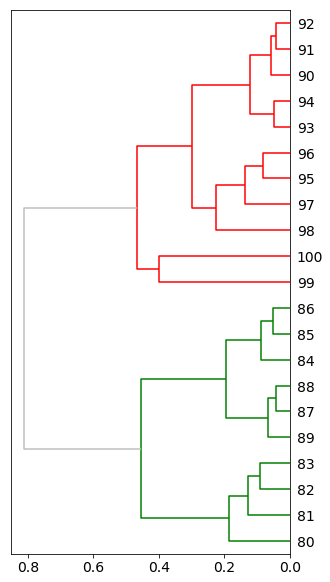

In [56]:
hca(points, color_thresh=.5, figsize=(5,10))

## By Province

In [57]:
provinces = create_matrix(corpus, 'province')

In [58]:
# top_provinces = provinces.sum(1).sort_values(ascending=False).head(45).index

<Figure size 432x288 with 0 Axes>

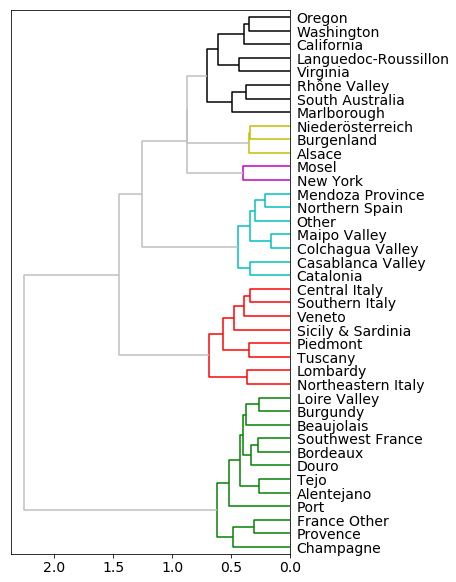

In [59]:
top_provinces = corpus['province'].value_counts().head(40).index
hca(provinces.loc[top_provinces], color_thresh = .8)

<Figure size 432x288 with 0 Axes>

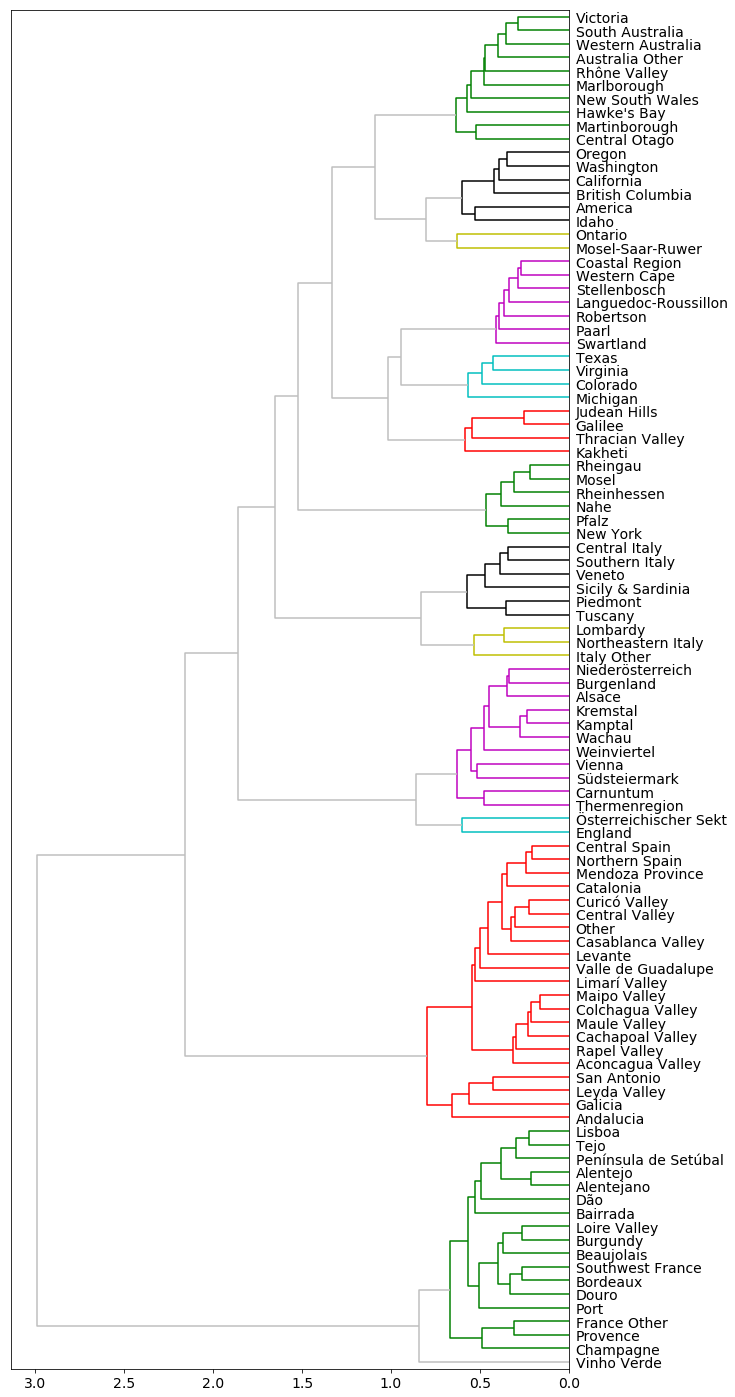

In [60]:
top_provinces = corpus['province'].value_counts().head(100).index
hca(provinces.loc[top_provinces], color_thresh = .8, figsize=(10,25))

## By Price

In [61]:
prices = create_matrix(corpus, 'price')

In [62]:
top_prices = corpus['price'].value_counts().head(50).index

<Figure size 432x288 with 0 Axes>

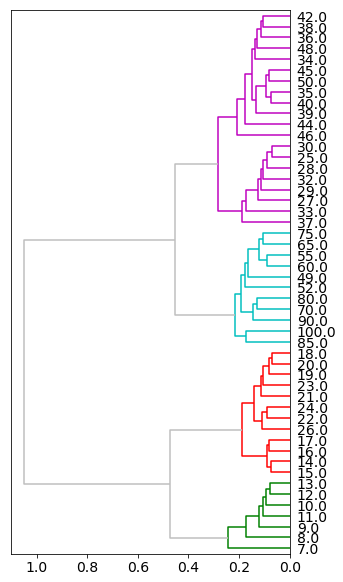

In [63]:
hca(prices.loc[top_prices])

In [64]:
# prices_tree = get_tree(prices.loc[top_prices])

In [65]:
# prices_tree

In [66]:
# varieties_tree = get_tree(varieties.loc[top_varieties])

In [67]:
# varieties_tree

# Test

In [71]:
mtabs

,nrows
table_name,
config,17
docword,2734441
topicword,79633
doctopic,2599420
topicphrase,200
topicword_diag,200
topicpair,190
topicdoc_label_pairs,903
topicdoc_points_pairs,210


In [72]:
tw = mdb.get_table('topicword')
twm = tw.set_index(['topic_id', 'word_id']).unstack().fillna(0)
twm = twm / twm.sum()

<Figure size 432x288 with 0 Axes>

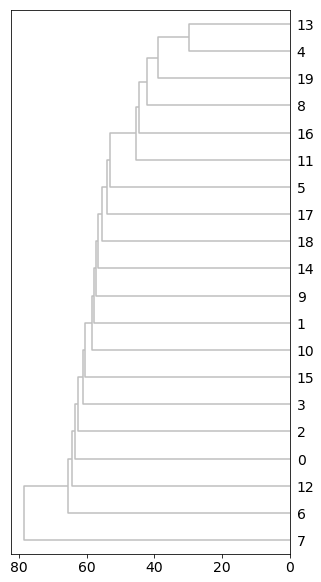

In [89]:
hca(twm)